In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

In [82]:
train_df = pd.read_csv("Datasets/train.csv")

In [83]:
# Feature Engineering and Data Cleaning
def cleaning_and_engineering(df):
    # Categorical Variables to Boolean Indicators
    df = pd.concat([df, pd.get_dummies(df.Pclass, prefix="Class")], axis=1)
    df = pd.concat([df, pd.get_dummies(df.Sex)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.Embarked, dummy_na=True, prefix="Embarked")], axis=1)

    # Handle Missing Ages
    df["MissingAge"] =  df["Age"].isnull().astype(int)
    df["Age"].fillna(0, inplace=True)

    # Handle Missing Fares
    df["MissingFare"] =  df["Fare"].isnull().astype(int)
    df["Fare"].fillna(0, inplace=True)

    # Drop Redundant / Unnecessary Cells
    df.drop(["Ticket", "Name", "PassengerId", "Pclass", "Sex", "Embarked", "Cabin"], axis=1, inplace=True)

    return df


clean_df = cleaning_and_engineering(train_df)
clean_df

,Survived,Age,SibSp,Parch,Fare,Class_1,Class_2,Class_3,female,male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,MissingAge,MissingFare
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,0,0,0
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,0,0,0
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,0,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,0,1,0,0,1,0,0,1,0,0,0
887,1,19.0,0,0,30.0000,1,0,0,1,0,0,0,1,0,0,0
888,0,0.0,1,2,23.4500,0,0,1,1,0,0,0,1,0,1,0
889,1,26.0,0,0,30.0000,1,0,0,0,1,1,0,0,0,0,0


In [84]:
# Write clean data to new file
clean_df.to_csv("Datasets/ABT.csv", index=False)

In [85]:
# Read in Data
data = pd.read_csv("Datasets/ABT.csv")
data

,Survived,Age,SibSp,Parch,Fare,Class_1,Class_2,Class_3,female,male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,MissingAge,MissingFare
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,0,0,0
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,0,0,0
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,0,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,0,1,0,0,1,0,0,1,0,0,0
887,1,19.0,0,0,30.0000,1,0,0,1,0,0,0,1,0,0,0
888,0,0.0,1,2,23.4500,0,0,1,1,0,0,0,1,0,1,0
889,1,26.0,0,0,30.0000,1,0,0,0,1,1,0,0,0,0,0


In [86]:
X = data.drop("Survived", axis=1)
y = data["Survived"]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [88]:
# Ridge Classification CV
alphas = [1*10**(5-x) for x in range(0, 10)]

ridge_model = RidgeClassifierCV(alphas=alphas, cv=10)
ridge_score = np.mean(cross_val_score(ridge_model, X_train, y_train, cv=10))

ridge_score

0.7995477159656263

In [89]:
# Lasso Regression CV
Cs = 10

logistic_model = LogisticRegressionCV(Cs=Cs, cv=10, max_iter=1000, penalty="l2", solver="liblinear")
logistic_score = np.mean(cross_val_score(logistic_model, X_train, y_train, cv=10))

logistic_score

0.8055178652193578

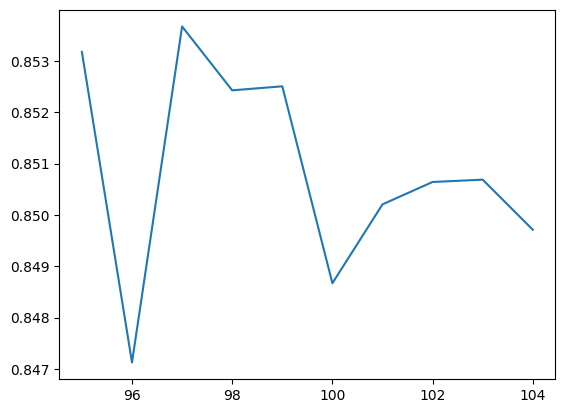

In [90]:
# Random Forest Classification
random_trees = [x for x in range(95, 105, 1)]
random_forest_cross_val_scores = []
random_forests = []

for t in random_trees:
    model = RandomForestClassifier(n_estimators=t)
    score = np.mean(cross_val_score(model, X_train, y_train, cv=10, scoring="roc_auc"))
    random_forest_cross_val_scores.append(score)
    random_forests.append(model)

#
#
plt.plot(random_trees, random_forest_cross_val_scores)

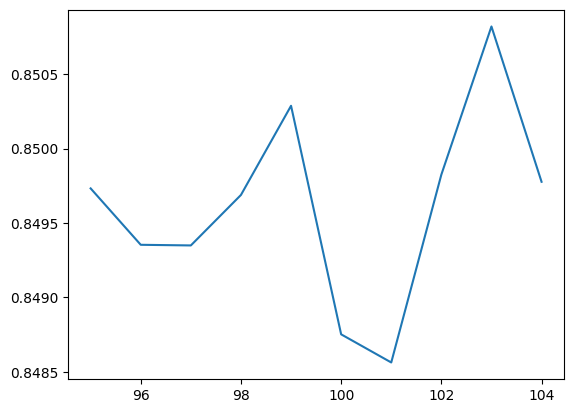

In [91]:
# Gradient Boosted Classifier
boosted_tree_stages = [x for x in range(95, 105, 1)]
boosted_tree_cross_val_scores = []
boosted_trees = []

for t in boosted_tree_stages:
    model = GradientBoostingClassifier(n_estimators=t)
    score = np.mean(cross_val_score(model, X_train, y_train, cv=10, scoring="roc_auc"))
    boosted_tree_cross_val_scores.append(score)
    boosted_trees.append(model)

#
#
plt.plot(boosted_tree_stages, boosted_tree_cross_val_scores)

In [92]:
# Neural Net Classifier
# Can't really get accuracy above 80 even with Cross Val to optimize parameters

def find_best_parameters():
    epochs = [5, 10, 15, 20]
    size = [16, 32, 64, 128]
    neural_net_scores = []

    for e in epochs:
        for s in size:
            neural_net_scores.append(neural_net_cross_val_score(e, s))

def neural_net_cross_val_score(eps, sz):
    scrs = []
    for train, test in KFold(10).split(X_train, y_train):
        nn = Sequential()
        nn.add(Dense(sz, activation="relu"))
        nn.add(Dense(1, activation="sigmoid"))
        nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        nn.fit(X_train.iloc[train], y_train.iloc[train], epochs=eps, shuffle=True, verbose=0)
        test_loss, test_acc = nn.evaluate(X_train.iloc[test], y_train.iloc[test], verbose=2)
        scrs.append(test_acc)
    return sum(scrs) / len(scrs)

neural_net = Sequential()
neural_net.add(Dense(256, activation="relu"))
neural_net.add(Dense(128, activation="relu"))
neural_net.add(Dense(64, activation="softmax"))
neural_net.add(Dense(1, activation="sigmoid"))
neural_net.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])



In [93]:
best_models = [neural_net, ridge_model, logistic_model]
for scores, models in [(random_forest_cross_val_scores, random_forests), (boosted_tree_cross_val_scores, boosted_trees)]:
    best_score = max(scores)
    best_models.append(models[scores.index(best_score)])

for model in best_models:
    if best_models.index(model) == 0:
        model.fit(X_train, y_train, epochs=10)
        continue
    model.fit(X_train, y_train)

best_model_scores = []
for i in range(len(best_models)):
    predictions = best_models[i].predict(X_test)
    if len(predictions.shape) > 1:
        predictions = np.round(predictions.flatten()).astype(int)
    acc = roc_auc_score(y_test, predictions)
    best_model_scores.append(acc)

best_model_scores

Epoch 1/10
21/21 [==============================] - 6s 6ms/step - loss: 0.6639 - accuracy: 0.6557
Epoch 2/10
21/21 [==============================] - 0s 5ms/step - loss: 0.6541 - accuracy: 0.6811
Epoch 3/10
21/21 [==============================] - 0s 5ms/step - loss: 0.6456 - accuracy: 0.6901
Epoch 4/10
21/21 [==============================] - 0s 6ms/step - loss: 0.6367 - accuracy: 0.7111
Epoch 5/10
21/21 [==============================] - 0s 6ms/step - loss: 0.6314 - accuracy: 0.7111
Epoch 6/10
21/21 [==============================] - 0s 13ms/step - loss: 0.6273 - accuracy: 0.7201
Epoch 7/10
21/21 [==============================] - 0s 7ms/step - loss: 0.6198 - accuracy: 0.7051
Epoch 8/10
21/21 [==============================] - 0s 7ms/step - loss: 0.6132 - accuracy: 0.7096
Epoch 9/10
21/21 [==============================] - 0s 6ms/step - loss: 0.6077 - accuracy: 0.7006
Epoch 10/10
21/21 [==============================] - 0s 6ms/step - loss: 0.5923 - accuracy: 0.7410


[0.6949941304712393,
 0.7736458158644977,
 0.7698725473754822,
 0.7998490692604394,
 0.8054251215830958]

In [94]:
def show_tree_feature_importance(tree):
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
    feature_importance = tree.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, np.array(X.columns)[sorted_idx])
    plt.title("Feature Importance (MDI)")

    result = permutation_importance(
        tree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=np.array(X.columns)[sorted_idx],
    )
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()

In [95]:
ridge_model = best_models[2]
r_coef_df = pd.DataFrame(ridge_model.coef_)
r_coef_df.columns = X.columns
r_coef_df


,Age,SibSp,Parch,Fare,Class_1,Class_2,Class_3,female,male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,MissingAge,MissingFare
0,-0.014041,-0.132974,-0.005189,0.006391,0.438583,0.185839,-0.557461,0.934549,-0.867587,0.169074,-0.050437,-0.071931,0.020256,-0.270993,0.0


In [96]:
logistic_model = best_models[2]
l_coef_df = pd.DataFrame(logistic_model.coef_)
l_coef_df.columns = X.columns
l_coef_df

,Age,SibSp,Parch,Fare,Class_1,Class_2,Class_3,female,male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,MissingAge,MissingFare
0,-0.014041,-0.132974,-0.005189,0.006391,0.438583,0.185839,-0.557461,0.934549,-0.867587,0.169074,-0.050437,-0.071931,0.020256,-0.270993,0.0


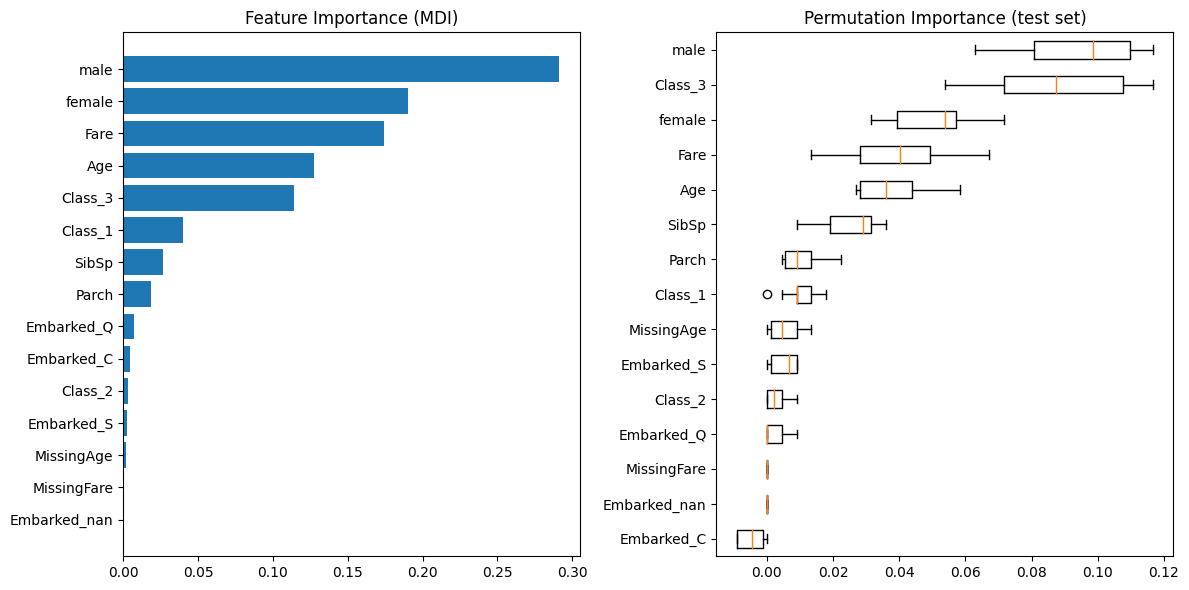

In [97]:
boosted_tree = best_models[-1]
show_tree_feature_importance(boosted_tree)

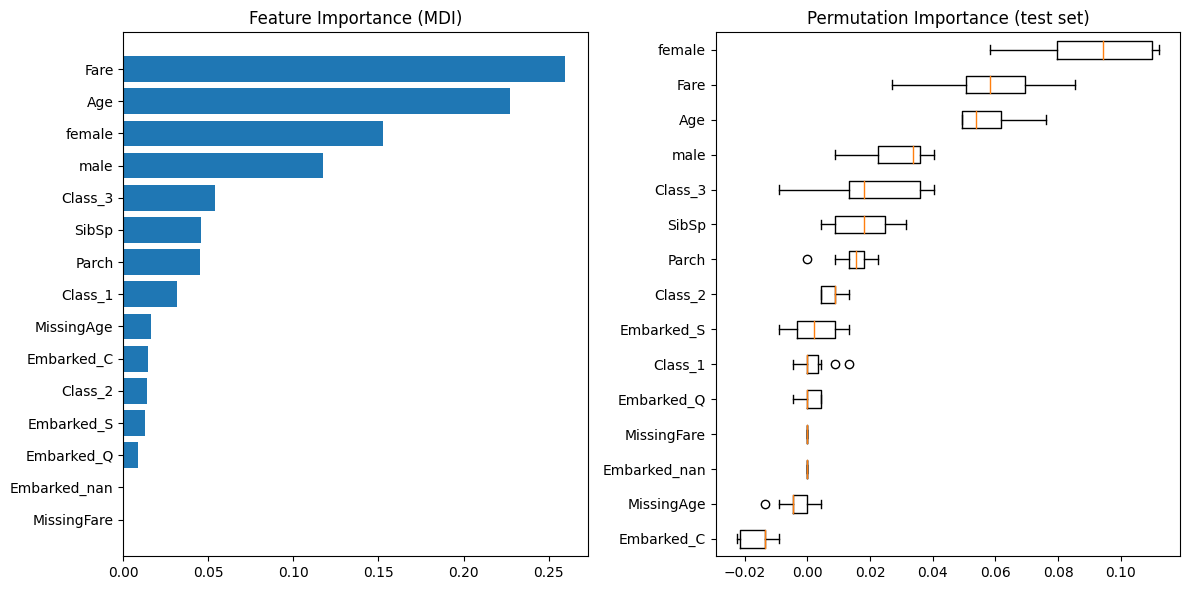

In [98]:
random_tree = best_models[-2]
show_tree_feature_importance(random_tree)

In [99]:
test_df = pd.read_csv("Datasets/test.csv")
kaggle_test_df = cleaning_and_engineering(test_df)
kaggle_test_df

,Age,SibSp,Parch,Fare,Class_1,Class_2,Class_3,female,male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,MissingAge,MissingFare
0,34.5,0,0,7.8292,0,0,1,0,1,0,1,0,0,0,0
1,47.0,1,0,7.0000,0,0,1,1,0,0,0,1,0,0,0
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,0,0,0,0
3,27.0,0,0,8.6625,0,0,1,0,1,0,0,1,0,0,0
4,22.0,1,1,12.2875,0,0,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,0,0,8.0500,0,0,1,0,1,0,0,1,0,1,0
414,39.0,0,0,108.9000,1,0,0,1,0,1,0,0,0,0,0
415,38.5,0,0,7.2500,0,0,1,0,1,0,0,1,0,0,0
416,0.0,0,0,8.0500,0,0,1,0,1,0,0,1,0,1,0


In [100]:
kaggle_xs = kaggle_test_df
predictor = best_models[best_model_scores.index(max(best_model_scores))]
kaggle_ys = np.round(predictor.predict(kaggle_xs)).astype(int)

In [101]:
kaggle_output_df = pd.DataFrame(kaggle_ys, columns=["Survived"])

kaggle_output_df["PassengerId"] = kaggle_output_df.index + 892
kaggle_output_df.to_csv("Datasets/kaggle_submission.csv", index=False)

In [102]:
kaggle_output_df

,Survived,PassengerId
0,0,892
1,0,893
2,0,894
3,0,895
4,1,896
...,...,...
413,0,1305
414,1,1306
415,0,1307
416,0,1308
